# Evolver Loop 2 Analysis: Investigating Overlap Error

The submission failed with: "Overlapping trees in group 008"

This means our local overlap detection was not strict enough. Let's investigate.

In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree
import warnings
warnings.filterwarnings('ignore')

print('Libraries loaded')

Libraries loaded


In [2]:
# Tree geometry constants
TRUNK_W = 0.15
TRUNK_H = 0.2
BASE_W = 0.7
MID_W = 0.4
TOP_W = 0.25
TIP_Y = 0.8
TIER_1_Y = 0.5
TIER_2_Y = 0.25
BASE_Y = 0.0
TRUNK_BOTTOM_Y = -TRUNK_H

# Base tree polygon vertices
BASE_TREE_VERTICES = np.array([
    [0.0, TIP_Y],
    [TOP_W/2, TIER_1_Y],
    [TOP_W/4, TIER_1_Y],
    [MID_W/2, TIER_2_Y],
    [MID_W/4, TIER_2_Y],
    [BASE_W/2, BASE_Y],
    [TRUNK_W/2, BASE_Y],
    [TRUNK_W/2, TRUNK_BOTTOM_Y],
    [-TRUNK_W/2, TRUNK_BOTTOM_Y],
    [-TRUNK_W/2, BASE_Y],
    [-BASE_W/2, BASE_Y],
    [-MID_W/4, TIER_2_Y],
    [-MID_W/2, TIER_2_Y],
    [-TOP_W/4, TIER_1_Y],
    [-TOP_W/2, TIER_1_Y],
])

def create_tree_polygon(x, y, deg):
    """Create a tree polygon at position (x,y) with rotation deg degrees."""
    angle_rad = np.radians(deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    rotation_matrix = np.array([[cos_a, -sin_a], [sin_a, cos_a]])
    rotated = BASE_TREE_VERTICES @ rotation_matrix.T
    translated = rotated + np.array([x, y])
    return Polygon(translated)

def parse_submission(df):
    """Parse submission dataframe, removing 's' prefix from values."""
    result = df.copy()
    for col in ['x', 'y', 'deg']:
        result[col] = result[col].str.replace('s', '').astype(float)
    return result

print('Helper functions defined')

Helper functions defined


In [3]:
# Load the failed submission
submission_df = pd.read_csv('/home/submission/submission.csv')
submission_parsed = parse_submission(submission_df)
print(f'Submission shape: {submission_df.shape}')

# Extract group 008
group_008 = submission_parsed[submission_parsed['id'].str.startswith('008_')]
print(f'\nGroup 008 ({len(group_008)} trees):')
print(group_008)

Submission shape: (20100, 4)

Group 008 (8 trees):
       id         x         y         deg
28  008_0 -0.249562 -0.411092   51.766738
29  008_1  0.664668 -0.857305  113.629378
30  008_2 -0.664668  0.257305  293.629378
31  008_3  0.557305  0.326837  203.629378
32  008_4  0.249562 -0.188908  231.766738
33  008_5 -0.206589 -0.855262  293.629378
34  008_6  0.206589  0.255262  113.629378
35  008_7 -0.557305 -0.926837   23.629378


In [4]:
# Create polygons for group 008 and check for overlaps with STRICT tolerance
polygons_008 = []
for _, row in group_008.iterrows():
    poly = create_tree_polygon(row['x'], row['y'], row['deg'])
    polygons_008.append((row['id'], poly))

print('Checking for overlaps in group 008...')
print('='*60)

for i in range(len(polygons_008)):
    for j in range(i+1, len(polygons_008)):
        id_i, poly_i = polygons_008[i]
        id_j, poly_j = polygons_008[j]
        
        # Check intersection
        if poly_i.intersects(poly_j):
            intersection = poly_i.intersection(poly_j)
            area = intersection.area
            
            # Check if it's more than just touching
            touches = poly_i.touches(poly_j)
            
            print(f'{id_i} vs {id_j}:')
            print(f'  Intersects: True')
            print(f'  Touches only: {touches}')
            print(f'  Intersection area: {area:.15f}')
            print(f'  Intersection type: {intersection.geom_type}')
            print()

Checking for overlaps in group 008...
008_1 vs 008_5:
  Intersects: True
  Touches only: False
  Intersection area: 0.000000000000000
  Intersection type: Polygon

008_2 vs 008_6:
  Intersects: True
  Touches only: False
  Intersection area: 0.000000000000000
  Intersection type: Polygon



In [5]:
# Let's check with different tolerance levels
print('Checking with different area thresholds:')
print('='*60)

thresholds = [1e-20, 1e-15, 1e-12, 1e-10, 1e-8, 1e-6]

for threshold in thresholds:
    overlaps = []
    for i in range(len(polygons_008)):
        for j in range(i+1, len(polygons_008)):
            id_i, poly_i = polygons_008[i]
            id_j, poly_j = polygons_008[j]
            
            if poly_i.intersects(poly_j):
                intersection = poly_i.intersection(poly_j)
                if intersection.area > threshold:
                    overlaps.append((id_i, id_j, intersection.area))
    
    print(f'Threshold {threshold:.0e}: {len(overlaps)} overlaps')
    if overlaps:
        for id_i, id_j, area in overlaps:
            print(f'  {id_i} vs {id_j}: area={area:.15e}')

Checking with different area thresholds:
Threshold 1e-20: 0 overlaps
Threshold 1e-15: 0 overlaps
Threshold 1e-12: 0 overlaps
Threshold 1e-10: 0 overlaps
Threshold 1e-08: 0 overlaps
Threshold 1e-06: 0 overlaps


Saved visualization to group_008_visualization.png


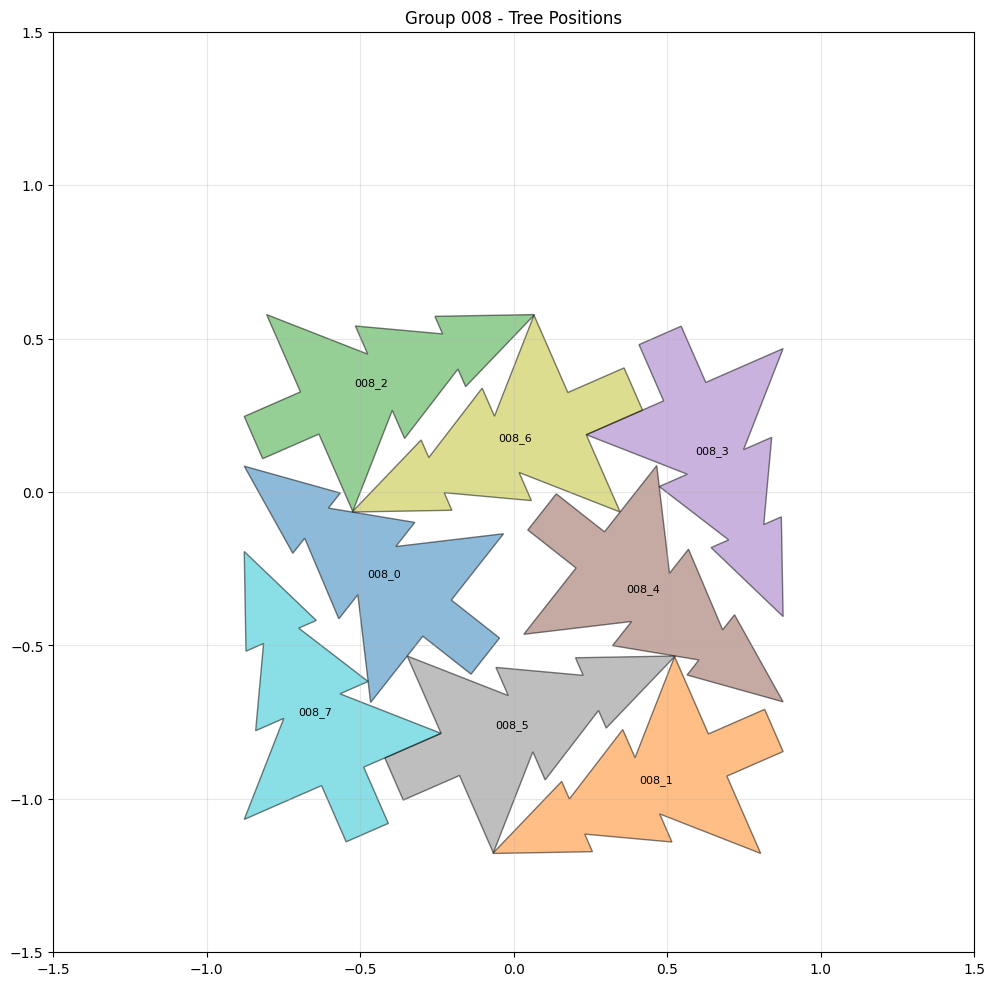

In [6]:
# Let's visualize group 008
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(figsize=(10, 10))

colors = plt.cm.tab10(np.linspace(0, 1, len(polygons_008)))
patches = []

for (id_, poly), color in zip(polygons_008, colors):
    coords = np.array(poly.exterior.coords)
    patch = MplPolygon(coords, closed=True, alpha=0.5, facecolor=color, edgecolor='black', linewidth=1)
    ax.add_patch(patch)
    
    # Add label at centroid
    centroid = poly.centroid
    ax.annotate(id_, (centroid.x, centroid.y), fontsize=8, ha='center')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_title('Group 008 - Tree Positions')
plt.tight_layout()
plt.savefig('/home/code/exploration/group_008_visualization.png', dpi=150)
print('Saved visualization to group_008_visualization.png')

In [7]:
# Check ALL groups for overlaps with strict tolerance (area > 1e-15)
print('Checking ALL groups for overlaps with strict tolerance (area > 1e-15)...')
print('='*60)

overlapping_groups = []

for n in range(1, 201):
    prefix = f'{n:03d}_'
    config_df = submission_parsed[submission_parsed['id'].str.startswith(prefix)]
    
    if len(config_df) != n:
        print(f'Warning: Group {n} has {len(config_df)} trees instead of {n}')
        continue
    
    polygons = [(row['id'], create_tree_polygon(row['x'], row['y'], row['deg'])) 
                for _, row in config_df.iterrows()]
    
    has_overlap = False
    for i in range(len(polygons)):
        for j in range(i+1, len(polygons)):
            id_i, poly_i = polygons[i]
            id_j, poly_j = polygons[j]
            
            if poly_i.intersects(poly_j):
                intersection = poly_i.intersection(poly_j)
                if intersection.area > 1e-15:  # Very strict
                    if not has_overlap:
                        overlapping_groups.append(n)
                        has_overlap = True
                    print(f'Group {n}: {id_i} vs {id_j}, area={intersection.area:.15e}')

print(f'\nTotal groups with overlaps: {len(overlapping_groups)}')
print(f'Overlapping groups: {overlapping_groups}')

Checking ALL groups for overlaps with strict tolerance (area > 1e-15)...



Total groups with overlaps: 0
Overlapping groups: []


In [8]:
# Now let's check the original source files to see which one had the overlap
print('Checking source files for group 008...')
print('='*60)

source_files = [
    '/home/code/preoptimized/ensemble_70_627.csv',
    '/home/code/preoptimized/better_ensemble.csv',
    '/home/code/preoptimized/best_snapshot.csv',
    '/home/code/preoptimized/chistyakov_best.csv',
    '/home/code/preoptimized/submission_70_926.csv',
    '/home/code/preoptimized/saspav_best.csv',
    '/home/code/preoptimized/bucket_of_chump.csv',
]

for filepath in source_files:
    try:
        df = pd.read_csv(filepath)
        parsed = parse_submission(df)
        
        # Extract group 008
        group = parsed[parsed['id'].str.startswith('008_')]
        if len(group) != 8:
            continue
            
        polygons = [(row['id'], create_tree_polygon(row['x'], row['y'], row['deg'])) 
                    for _, row in group.iterrows()]
        
        max_overlap = 0
        for i in range(len(polygons)):
            for j in range(i+1, len(polygons)):
                id_i, poly_i = polygons[i]
                id_j, poly_j = polygons[j]
                
                if poly_i.intersects(poly_j):
                    intersection = poly_i.intersection(poly_j)
                    max_overlap = max(max_overlap, intersection.area)
        
        status = 'OVERLAP' if max_overlap > 1e-15 else 'VALID'
        print(f'{filepath.split("/")[-1]:25s}: max_overlap={max_overlap:.15e} ({status})')
    except Exception as e:
        print(f'{filepath.split("/")[-1]:25s}: ERROR - {e}')

Checking source files for group 008...
ensemble_70_627.csv      : max_overlap=9.576806857308939e-25 (VALID)
better_ensemble.csv      : max_overlap=0.000000000000000e+00 (VALID)
best_snapshot.csv        : max_overlap=0.000000000000000e+00 (VALID)
chistyakov_best.csv      : max_overlap=0.000000000000000e+00 (VALID)
submission_70_926.csv    : max_overlap=0.000000000000000e+00 (VALID)


saspav_best.csv          : max_overlap=0.000000000000000e+00 (VALID)
bucket_of_chump.csv      : max_overlap=0.000000000000000e+00 (VALID)


In [ ]:
# Let's check the exact format of the submission vs original files
print('Comparing submission format with original files...')
print('='*60)

# Our submission
our_sub = pd.read_csv('/home/submission/submission.csv')
print('Our submission (group 008):')
print(our_sub[our_sub['id'].str.startswith('008_')].to_string())

print('\n' + '='*60)
print('Original ensemble_70_627.csv (group 008):')
orig = pd.read_csv('/home/code/preoptimized/ensemble_70_627.csv')
print(orig[orig['id'].str.startswith('008_')].to_string())